<a href="https://colab.research.google.com/github/jakubgolab/Machine-Learning/blob/main/Statystyka_i_Analiza_Danych_Projekt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#<center>STATYSTYKA I ANALIZA DANYCH - PROJEKT</center>


Celem projektu jest analiza zbioru danych pochodzących ze strony [CRITEO AI LAB](https://ailab.criteo.com/criteo-sponsored-search-conversion-log-dataset/).
Ze względu na ograniczoną liczbę pamięci RAM, proces wyboru odpowiedniego partnera ze zbioru został dokonany na zewnętrznym serwerze. Poszukiwanie podzbioru zostało oparte o wyszukanie takiego podzbioru, dla którego po usunięciu wartości pustych ze zbioru głównego w zbiorze wyjściowym znajdowała się jak największa liczba zmiennych opisujących przy zachowaniu nadrzędnego kryterium jakim była jak największa liczba obserwacji. Finalnie wybrano podziór o identyfikatorze partner_id = F122B91F6D102E4630817566839A4F1F.

---
Jakub Gołąb
WIiT
Politechnika Poznańska

---





##Spis treści:


1.   [Przygotowanie Danych](#0)
2.   [Analiza Eksploracyjna](#1)
3.   [Szereg Czasowy i Kluczowe Wskaźniki Efektywności](#2)
4.   [Test Statystyczny](#3)
5.   [Feature Extraction](#4)
6.   [Selekcja Cech](#5)
7.   [Testowanie statystyczne wyselekcjonowanych cech](#6)
8.   [Dekompozycja widmowa zbioru wyselekcjonowanych zmiennych opisujących](#7)
9.   [Testowanie statystyczne głównych składowych zmiennych opisujących](#8)

### <a name='0'></a> Przygotowanie Danych

In [ ]:
# import potrzebnych bibliotek
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import datetime
from statsmodels.stats import weightstats as test
from scipy.stats import ttest_1samp as ttest
import featuretools as ft
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import utils
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import chi2
from scipy.stats import norm, shapiro
import statistics as st
from sklearn.decomposition import PCA

In [ ]:
# wczytanie danych dotyczących partnera o identyfikatorze: F122B91F6D102E4630817566839A4F1F
raw_data = pd.read_csv("/content/drive/MyDrive/Statystyka_i_Analiza_Danych_Projekt/dane_hashed.csv")
raw_data.drop('Unnamed: 0', axis=1, inplace=True)

In [ ]:
# wstępne sprawdzenie typów danych przechowywanych w naszym zbiorze
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98704 entries, 0 to 98703
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Sale                       98704 non-null  int64  
 1   SalesAmountInEuro          98704 non-null  float64
 2   time_delay_for_conversion  98704 non-null  float64
 3   click_timestamp            98704 non-null  object 
 4   nb_clicks_1week            98704 non-null  int64  
 5   product_price              98704 non-null  float64
 6   product_age_group          98704 non-null  object 
 7   device_type                98704 non-null  object 
 8   audience_id                98704 non-null  object 
 9   product_gender             98704 non-null  object 
 10  product_brand              98704 non-null  object 
 11  product_category           98704 non-null  object 
 12  product_id                 98704 non-null  object 
 13  product_title              98704 non-null  obj

In [ ]:
# zmiana typu danych dla kolumn click_timestamp oraz nb_clicks_1week
# raw_data['click_timestamp'] = pd.to_datetime(raw_data['click_timestamp'], unit='s')
raw_data['click_timestamp'] = pd.to_datetime(raw_data['click_timestamp'])
raw_data['nb_clicks_1week'] = raw_data['nb_clicks_1week'].astype('int64')

In [ ]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98704 entries, 0 to 98703
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Sale                       98704 non-null  int64         
 1   SalesAmountInEuro          98704 non-null  float64       
 2   time_delay_for_conversion  98704 non-null  float64       
 3   click_timestamp            98704 non-null  datetime64[ns]
 4   nb_clicks_1week            98704 non-null  int64         
 5   product_price              98704 non-null  float64       
 6   product_age_group          98704 non-null  object        
 7   device_type                98704 non-null  object        
 8   audience_id                98704 non-null  object        
 9   product_gender             98704 non-null  object        
 10  product_brand              98704 non-null  object        
 11  product_category           98704 non-null  object        
 12  prod

In [ ]:
# posortowanie danych chronologicznie
raw_data.sort_values(by='click_timestamp', inplace=True)
raw_data.reset_index(inplace=True, drop=True)
# raw_data.drop('Unnamed: 0.1', axis=1, inplace=True)

In [ ]:
# walidacja zbioru danych
today_date = datetime.date.today()
assert raw_data.isna().sum().sum() == 0
assert raw_data['click_timestamp'].max().date() <= today_date

In [ ]:
raw_data.head()

,Sale,SalesAmountInEuro,time_delay_for_conversion,click_timestamp,nb_clicks_1week,product_price,product_age_group,device_type,audience_id,product_gender,product_brand,product_category,product_id,product_title,user_id
0,0,0.0,0.0,2020-08-03 07:30:58,36,0.0,product_age_group_1,device_type_1,audience_id_1,product_gender_1,product_brand_1,product_category_1,product_id_1,product_title_1,user_id_1
1,0,0.0,0.0,2020-08-03 07:33:57,3,0.0,product_age_group_1,device_type_1,audience_id_2,product_gender_1,product_brand_2,product_category_2,product_id_2,product_title_2,user_id_2
2,0,0.0,0.0,2020-08-03 07:36:02,14,0.0,product_age_group_1,device_type_2,audience_id_3,product_gender_1,product_brand_3,product_category_3,product_id_3,product_title_3,user_id_3
3,0,0.0,0.0,2020-08-03 07:37:48,404,0.0,product_age_group_1,device_type_1,audience_id_4,product_gender_1,product_brand_4,product_category_1,product_id_4,product_title_4,user_id_4
4,0,0.0,0.0,2020-08-03 07:52:45,41,0.0,product_age_group_1,device_type_1,audience_id_5,product_gender_1,product_brand_5,product_category_1,product_id_5,product_title_5,user_id_5


Załóżmy, że dane zostaną wykorzystane do określenia predykcji sumy tranzakcji od zmiennych opisujących. Dlatego, też wyodrębnijmy te dane, gdzie tranzakcja została dokonana (innymi słowy, gdzie suma tranzakcji jest dodatnia).

In [ ]:
raw_data.nunique()

Sale                             2
SalesAmountInEuro             7979
time_delay_for_conversion    12579
click_timestamp              97459
nb_clicks_1week               1074
product_price                 1988
product_age_group                5
device_type                      3
audience_id                    103
product_gender                   3
product_brand                  311
product_category                15
product_id                    9360
product_title                 6799
user_id                      79647
dtype: int64

In [ ]:
# opuszczamy kolumnę zawierającą dane niestotne
# raw_data.drop('product_country', axis=1, inplace=True)

W celu poprawy czytelności i pracy z danymi, dokonajmy zastąpienia wartości "zhaszowanych" nowymi wartościami

In [ ]:
# to_be_hashed = ['product_age_group', 'product_gender', 'device_type', 'product_brand', 'product_category', 'product_id', 'product_title', 'user_id', 'audience_id']

# for element in to_be_hashed:
#   product = raw_data[element].unique()
#   product_value = list(product)
#   length = [element + '_' + str(i+1) for i in range(len(product))]
#   mapping = {key : value for (key, value) in zip(product, length)}
#   raw_data[element] = raw_data[element].replace(mapping)

In [ ]:
all_transactions = raw_data
conversions = raw_data[raw_data['Sale'] == 1]

##<a name=1></a>Analiza Eksploracyjna

Zacznijmy od przeanalizowania zmiennych kategorycznych

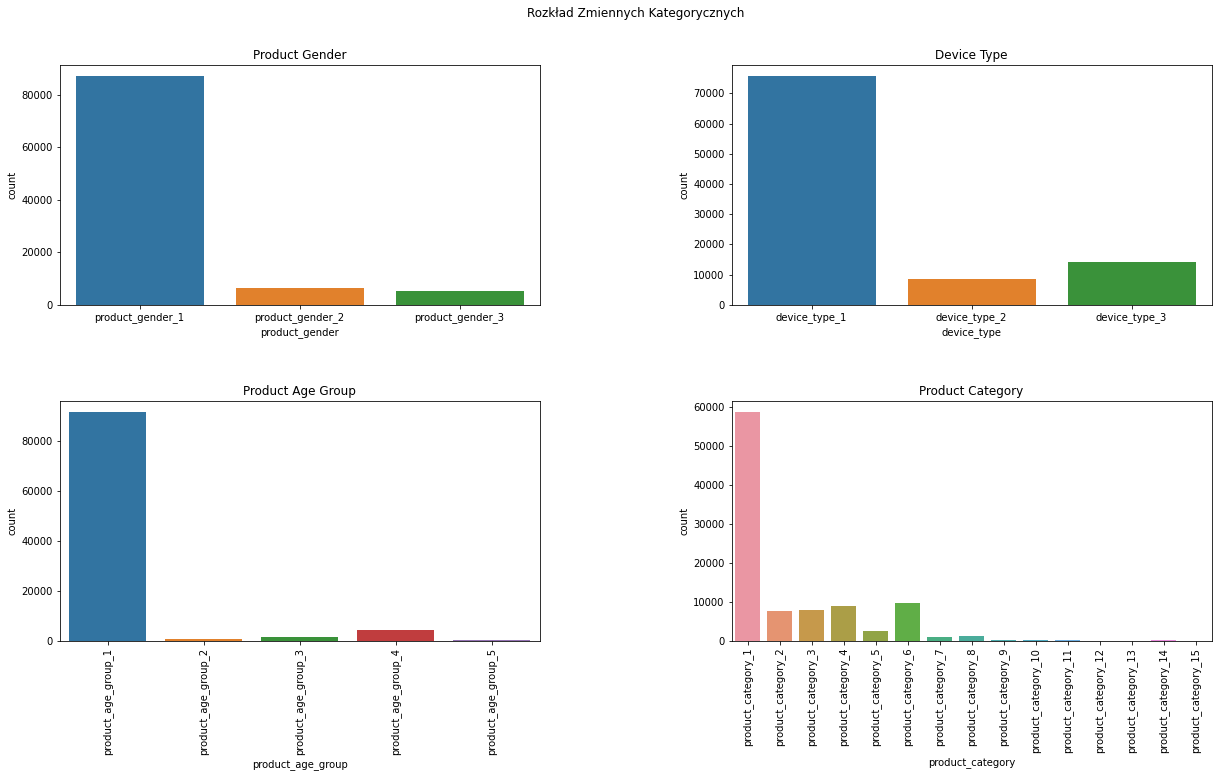

In [ ]:
# podstawowy rozkład zmiennych kategorycznych
fig, axes = plt.subplots(2, 2, figsize=(20, 10))
fig.suptitle("Rozkład Zmiennych Kategorycznych")

sns.countplot(ax=axes[0, 0], x=all_transactions['product_gender'])
axes[0, 0].set_title('Product Gender')

sns.countplot(ax=axes[1, 0], x=all_transactions['product_age_group'])
axes[1, 0].set_title('Product Age Group')
plt.sca(axes[1, 0])
plt.xticks(rotation=90)

sns.countplot(ax=axes[0, 1], x=all_transactions['device_type'])
axes[0, 1].set_title('Device Type')

sns.countplot(ax=axes[1, 1], x=all_transactions['product_category'])
axes[1, 1].set_title('Product Category')
plt.sca(axes[1, 1])
plt.xticks(rotation=90)

fig.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
fig.show()

In [ ]:
all_transactions[['product_gender', 'device_type', 'product_age_group', 'product_category']].describe()

,product_gender,device_type,product_age_group,product_category
count,98704,98704,98704,98704
unique,3,3,5,15
top,product_gender_1,device_type_1,product_age_group_1,product_category_1
freq,87093,75696,91589,58777


In [ ]:
print("Gender 1 : ", round((87093/98704)*100, 2), "%")
print("Device Type 1 : ", round((75696/98704)*100, 2), "%")
print("Product Age Group 1 : ", round((91589/98704)*100, 2), "%")
print("Product Category : ", round((58777/98704)*100, 2), "%")

Gender 1 :  88.24 %
Device Type 1 :  76.69 %
Product Age Group 1 :  92.79 %
Product Category :  59.55 %


Jak widać na powyższym zestawieniu mamy w naszym zbiorze danych pewne grupy osób, które wyraźnie przeważają swoją liczebnością. Są to odpowiednio:


*   Płeć numer 1   88.24%
*   Typ urządzenia nr 1   76.69%
*   Grupa wiekowa nr 1   92.79%
*   Kategoria produktowa nr 1   59.55%



Text(0.5, 1.0, 'Number Of Clicks')

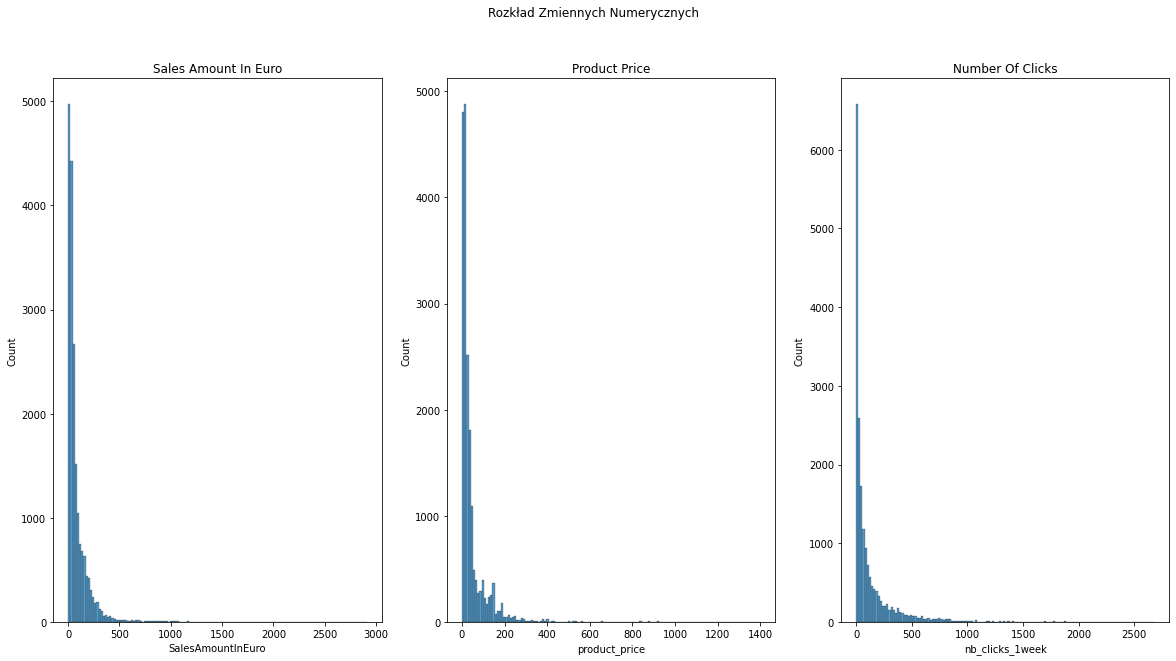

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(20, 10))
fig.suptitle("Rozkład Zmiennych Numerycznych")

sns.histplot(ax=axes[0], x=conversions['SalesAmountInEuro'], bins=int(np.sqrt(len(conversions))))
axes[0].set_title('Sales Amount In Euro')

sns.histplot(ax=axes[1], x=conversions['product_price'], bins=int(np.sqrt(len(conversions))))
axes[1].set_title('Product Price')

sns.histplot(ax=axes[2], x=conversions['nb_clicks_1week'], bins=int(np.sqrt(len(conversions))))
axes[2].set_title('Number Of Clicks')

In [ ]:
conversions[['SalesAmountInEuro', 'product_price', 'nb_clicks_1week']].describe()

,SalesAmountInEuro,product_price,nb_clicks_1week
count,19307.000000,19307.000000,19307.000000
mean,87.044102,46.913654,128.823380
std,127.327483,77.832300,224.166949
min,1.500000,0.830000,0.000000
25%,21.830000,11.170000,12.000000
50%,45.370000,21.000000,43.000000
75%,103.230000,45.745000,143.000000
max,2908.520000,1400.830000,2680.000000


In [ ]:
conversions[['SalesAmountInEuro', 'product_price', 'nb_clicks_1week']].median()

SalesAmountInEuro    45.37
product_price        21.00
nb_clicks_1week      43.00
dtype: float64

Dane charakteryzują się dużym rozrzutem oraz asymetrycznością. Dlatego też średnia nie jest w tym przypadku dobrą statystyką. Znacznie lepszym rodzajem statystyki będzie mediana, która wynosi odpowiednio 45.37 Euro dla sumy transakcji, 21 Euro dla ceny produktów oraz 43 dla tygodniowej liczby kliknięć w reklamę.

##<a name=2></a>Szereg Czasowy i Kluczowe Wskaźniki Efektywności

Szereg Czasowy



In [ ]:
conv_august = conversions[conversions['click_timestamp'].dt.month == 8]
conv_september = conversions[conversions['click_timestamp'].dt.month == 9]
conv_october = conversions[conversions['click_timestamp'].dt.month == 10]

conv_august = conv_august.groupby(conv_august.click_timestamp.dt.day)['Sale'].sum()
conv_september = conv_september.groupby(conv_september.click_timestamp.dt.day)['Sale'].sum()
conv_october = conv_october.groupby(conv_october.click_timestamp.dt.day)['Sale'].sum()

Text(0.5, 1.0, 'Październik')

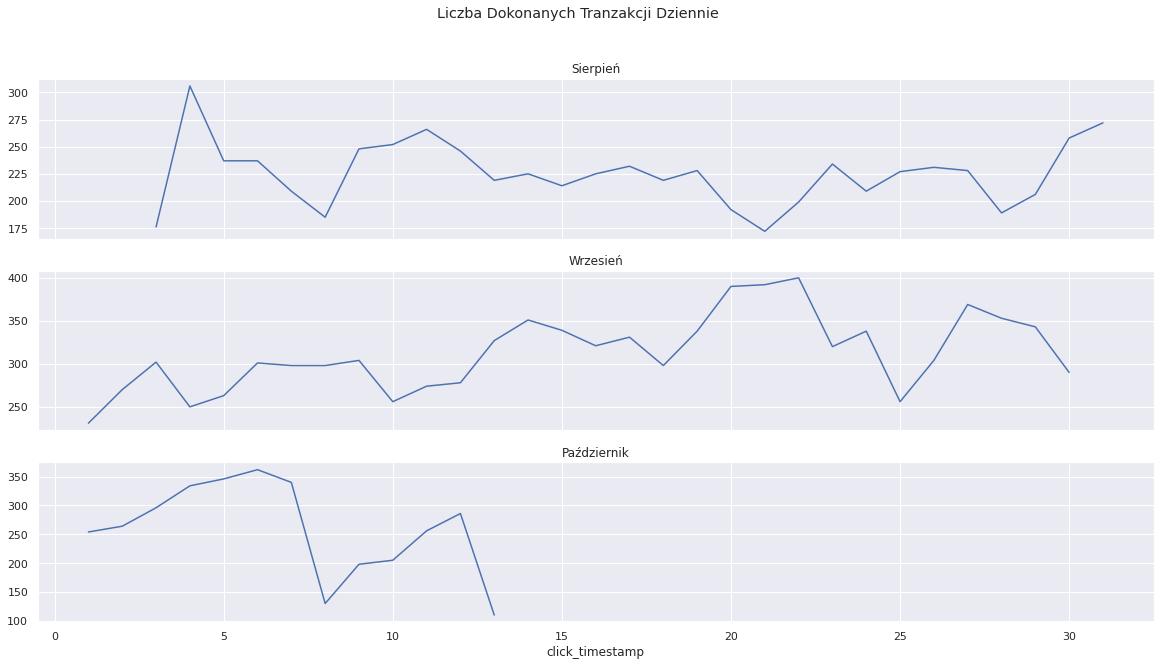

In [ ]:
sns.set()
fig, axes = plt.subplots(3, 1, figsize=(20, 10), sharex=True)
fig.suptitle('Liczba Dokonanych Tranzakcji Dziennie')

sns.lineplot(x=conv_august.index, y=conv_august.values, ax=axes[0])
axes[0].set_title('Sierpień')

sns.lineplot(x=conv_september.index, y=conv_september.values, ax=axes[1])
axes[1].set_title('Wrzesień')

sns.lineplot(x=conv_october.index, y=conv_october.values, ax=axes[2])
axes[2].set_title('Październik')

Kluczowe Wskaźniki Efektywności KPI:


*   Średnia wartość transakcji danego dnia
*   Dzienna suma konwersji przez dzienna liczba transakcji
*   Dzienna liczba konwersji przez dzienna liczba transakcji
*   Dzienna suma cen produktów przez dzienna suma konwersji

In [ ]:
sum_of_conv = conversions.groupby(conversions.click_timestamp.dt.day)['SalesAmountInEuro'].sum()
daily_mean = all_transactions.groupby(all_transactions.click_timestamp.dt.day)['SalesAmountInEuro'].mean()
nb_of_transactions = all_transactions.groupby(all_transactions.click_timestamp.dt.day)['SalesAmountInEuro'].count()
nb_of_conv = conversions.groupby(conversions.click_timestamp.dt.day)['Sale'].sum()
prod_price_sum = conversions.groupby(conversions.click_timestamp.dt.day)['product_price'].sum()

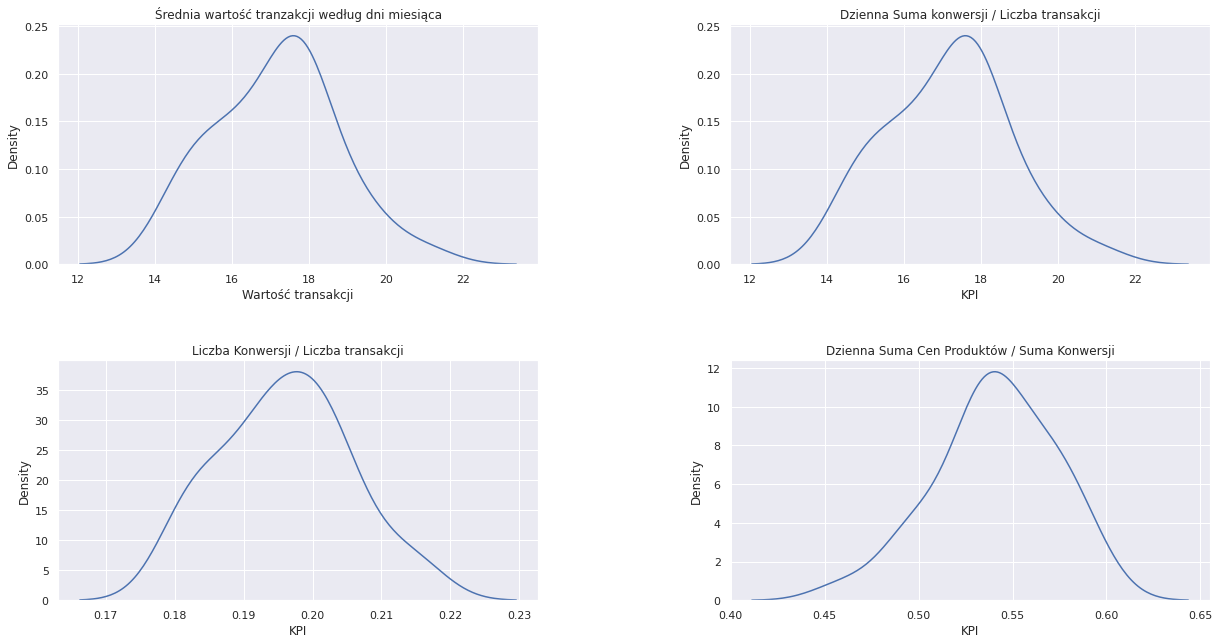

In [ ]:
sns.set()
fig, axes = plt.subplots(2, 2, figsize=(20, 10))

sns.kdeplot(daily_mean, ax=axes[0, 0])
axes[0, 0].set_title('Średnia wartość tranzakcji według dni miesiąca')
axes[0, 0].set_xlabel('Wartość transakcji')
axes[0, 0].set_ylabel('Density')

sns.kdeplot(sum_of_conv/nb_of_transactions, ax=axes[0, 1])
axes[0, 1].set_title('Dzienna Suma konwersji / Liczba transakcji')
axes[0, 1].set_xlabel('KPI')
axes[0, 1].set_ylabel('Density')

sns.kdeplot(nb_of_conv/nb_of_transactions, ax=axes[1, 0])
axes[1, 0].set_title('Liczba Konwersji / Liczba transakcji')
axes[1, 0].set_xlabel('KPI')
axes[1, 0].set_ylabel('Density')

sns.kdeplot(prod_price_sum/sum_of_conv, ax=axes[1, 1])
axes[1, 1].set_title('Dzienna Suma Cen Produktów / Suma Konwersji')
axes[1, 1].set_xlabel('KPI')
axes[1, 1].set_ylabel('Density')

fig.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
fig.show()

## <a name=3></a>Test Statystyczny

###Test Statystyczny średnia dzienna suma dokonanych transakcji

Dokonamy teraz testowania statystycznego jednego z obliczonych wcześniej Kluczowych Wskaźników Efektywności (średnia dzienna suma konwersji)

In [ ]:
sample = all_transactions.sample(frac=0.01, random_state=42)
daily_mean_sample = sample.groupby(sample.click_timestamp.dt.day)['SalesAmountInEuro'].mean()
print("Średnia z próby: ", round(np.mean(daily_mean_sample), 2))

Średnia z próby:  20.54


Korzystając z testu Z sprawdzimy czy średnia dzienna wartość zakupów dla naszego partnera jest różna od 17.15 Euro.

$$
H_0:μ_0=20.54\\
H_1:\mu_0\neq20.54
$$

In [ ]:
mu_pop = np.mean(daily_mean)
sigma_pop = np.std(daily_mean)
alpha = 0.05


mu = np.mean(daily_mean_sample)
n = len(daily_mean_sample)

stats, p_value = test.ztest(daily_mean_sample, value=mu_pop, alternative='two-sided')

if (p_value >= alpha/2):
  print('Brak podstaw do odrzucenia hipotezy zerowej')
else:
  print('Odrzucamy hipotezę zerową i przyjmujemy hipotezę alternatywną')

Brak podstaw do odrzucenia hipotezy zerowej


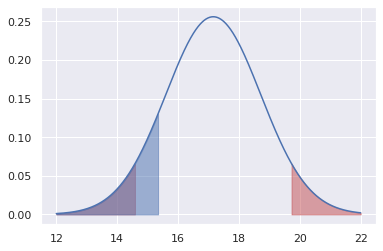

In [ ]:
x_axis = np.arange(12, 22, 0.01)
y_axis = norm.pdf(x_axis, mu_pop, sigma_pop)
plt.fill_between(x_axis, y_axis, where=x_axis < norm.ppf(0.05, loc=mu_pop, scale=sigma_pop), alpha=0.5, color='r')
plt.fill_between(x_axis, y_axis, where=x_axis > norm.ppf(0.95, loc=mu_pop, scale=sigma_pop), alpha=0.5, color='r')
plt.fill_between(x_axis, y_axis, where=x_axis < norm.ppf(p_value, loc=mu_pop, scale=sigma_pop), alpha=0.5, color='b')
plt.plot(x_axis, y_axis)
plt.show()

Na poziomie istotności 5% finalnie otrzymujemy wynik testu mówiący, że nie odrzucamy hipotezy zerowej. Zatem średnia dzienna wartość zakupów nie jest różna od 17.15 Euro.

###Test statystyczny średniej dziennej liczby dokonanych tranzakcji

In [ ]:
sample = all_transactions.sample(frac=0.01, random_state=42)
ratio = sample.groupby(sample.click_timestamp.dt.day)['Sale'].sum() / len(sample.groupby(sample.click_timestamp.dt.day)['Sale'])
print("Średnia z próby: ", round(np.mean(nb_of_conv/nb_of_transactions), 2))

Średnia z próby:  0.2


Korzystając z testu Z sprawdzimy czy średnio spośród wszystkich klientów klikających w reklamę naszego partnera dziennie zakupy robi 20% z nich.
$$H_0:μ_0=0.2$$
$$H_1:μ_0\neq0.2$$

In [ ]:
mu_pop = np.mean(nb_of_conv/nb_of_transactions)
sigma_pop = np.std(nb_of_conv/nb_of_transactions)
alpha = 0.05

mu = np.mean(ratio)
n = len(ratio)

stats, p_value = test.ztest(ratio, value=mu_pop, alternative='two-sided')

if (p_value >= alpha/2):
  print('Brak podstaw do odrzucenia hipotezy zerowej')
else:
  print('Odrzucamy hipotezę zerową i przyjmujemy hipotezę alternatywną')

Brak podstaw do odrzucenia hipotezy zerowej


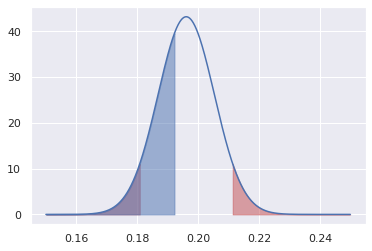

In [ ]:
x_axis = np.arange(0.15, 0.25, 0.0001)
y_axis = norm.pdf(x_axis, mu_pop, sigma_pop)
plt.fill_between(x_axis, y_axis, where=x_axis < norm.ppf(0.05, loc=mu_pop, scale=sigma_pop), alpha=0.5, color='r')
plt.fill_between(x_axis, y_axis, where=x_axis > norm.ppf(0.95, loc=mu_pop, scale=sigma_pop), alpha=0.5, color='r')
plt.fill_between(x_axis, y_axis, where=x_axis < norm.ppf(p_value, loc=mu_pop, scale=sigma_pop), alpha=0.5, color='b')
plt.plot(x_axis, y_axis)
plt.show()

Na poziomie istotności 5% finalnie otrzymujemy wynik testu mówiący, że nie odrzucamy hipotezy zerowej. Zatem średni dzienny odstetek klientów robiących zakupy wynosi 20%.

##<a name=4></a>Feature Exctraction

In [ ]:
# Na początek utwórzmy id dla każdej transakcji
conversions['transaction_id'] = np.arange(len(conversions))

In [ ]:
products_info = conversions[['product_id', 'product_price', 'product_age_group', 'product_gender', 'product_brand', 'product_category', 'product_title', 'user_id', 'transaction_id']]
transactions = conversions[['user_id', 'time_delay_for_conversion', 'click_timestamp', 'nb_clicks_1week', 'transaction_id', 'SalesAmountInEuro', 'product_id']]

products_info.drop_duplicates(subset=['product_id'], inplace=True)
transactions.drop_duplicates(subset=['transaction_id'], inplace=True)

In [ ]:
conversions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19307 entries, 34 to 98701
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Sale                       19307 non-null  int64         
 1   SalesAmountInEuro          19307 non-null  float64       
 2   time_delay_for_conversion  19307 non-null  float64       
 3   click_timestamp            19307 non-null  datetime64[ns]
 4   nb_clicks_1week            19307 non-null  int64         
 5   product_price              19307 non-null  float64       
 6   product_age_group          19307 non-null  object        
 7   device_type                19307 non-null  object        
 8   audience_id                19307 non-null  object        
 9   product_gender             19307 non-null  object        
 10  product_brand              19307 non-null  object        
 11  product_category           19307 non-null  object        
 12  pro

In [ ]:
es = ft.EntitySet(id="transactions")

es = es.add_dataframe(dataframe_name="products_info",
           dataframe=products_info,
           index="product_id")

es = es.add_dataframe(dataframe_name="transactions",
           dataframe=transactions,
           index="transaction_id",
           time_index='click_timestamp')

r = ft.Relationship(es, "products_info", "product_id",
                                   "transactions", "product_id")

es.add_relationship(relationship=r)

Entityset: transactions
  DataFrames:
    products_info [Rows: 5164, Columns: 9]
    transactions [Rows: 19307, Columns: 7]
  Relationships:
    transactions.product_id -> products_info.product_id

In [ ]:
feature_matrix, feature_defs = ft.dfs(entityset=es,
                                      target_dataframe_name="transactions",
                                      trans_primitives=['time_since', 'day', 'is_weekend',
                                                        'cum_min', 'minute', 'weekday',
                                                        'percentile', 'week', 'month',
                                                        'cum_mean'],
                                      agg_primitives=['mean', 'count', 'median'],
                                      max_depth=2)

In [ ]:
# Wygenerowane cechy
feature_matrix.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19307 entries, 0 to 19306
Data columns (total 38 columns):
 #   Column                                                        Non-Null Count  Dtype   
---  ------                                                        --------------  -----   
 0   time_delay_for_conversion                                     19307 non-null  float64 
 1   nb_clicks_1week                                               19307 non-null  int64   
 2   SalesAmountInEuro                                             19307 non-null  float64 
 3   CUM_MEAN(SalesAmountInEuro)                                   19307 non-null  float64 
 4   CUM_MEAN(nb_clicks_1week)                                     19307 non-null  float64 
 5   CUM_MEAN(time_delay_for_conversion)                           19307 non-null  float64 
 6   CUM_MIN(SalesAmountInEuro)                                    19307 non-null  float64 
 7   CUM_MIN(nb_clicks_1week)                                  

##<a name=5></a>Selekcja cech

Selekcja cech przy użyciu testu χ2

In [ ]:
# Dane dla wersji z cechami jakościowymi (konwersja na ilościowe)
features1 = feature_matrix.copy()
target1 = features1.pop('SalesAmountInEuro')
features1 = pd.get_dummies(features1)

# Dane dla wersji bez cech jakościowych
features2 = feature_matrix.copy()
target2 = features2.pop('SalesAmountInEuro')
to_be_dropped = ['DAY(click_timestamp)', 'MINUTE(click_timestamp)', 'MONTH(click_timestamp)', 'WEEK(click_timestamp)', 'WEEKDAY(click_timestamp)', 'products_info.product_age_group',
                 'products_info.product_gender', 'products_info.product_brand', 'products_info.product_category']
features2.drop(to_be_dropped, axis=1, inplace=True)

In [ ]:
lab_enc = preprocessing.LabelEncoder()
target1 = lab_enc.fit_transform(target1)
target2 = lab_enc.fit_transform(target2)

In [ ]:
selector = SelectPercentile(chi2, percentile=10)
selector.fit(features1, target1)
names = selector.get_feature_names_out(features1.columns)
values = selector.transform(features1)

In [ ]:
df1 = pd.DataFrame(data=values, columns=names)

In [ ]:
selector = SelectPercentile(chi2, percentile=30)
selector.fit(features2, target2)
names = selector.get_feature_names_out(features2.columns)
values = selector.transform(features2)

In [ ]:
df2 = pd.DataFrame(data=values, columns=names)

##<a name=6></a>Test statystyczny wyselekcjonowanych zmiennych opisujących

Na początek dodajmy do naszych wyselekcjonowanych zmiennych kolumny z datą oraz wartości transakcji

In [ ]:
df2.columns

Index(['time_delay_for_conversion', 'nb_clicks_1week',
       'CUM_MEAN(time_delay_for_conversion)', 'TIME_SINCE(click_timestamp)',
       'products_info.transaction_id',
       'products_info.MEAN(transactions.time_delay_for_conversion)',
       'products_info.MEDIAN(transactions.nb_clicks_1week)',
       'products_info.MEDIAN(transactions.time_delay_for_conversion)',
       'products_info.CUM_MEAN(transaction_id)'],
      dtype='object')

In [ ]:
merged = pd.concat([df2, conversions[['click_timestamp', 'product_id', 'SalesAmountInEuro']]], axis=1)

Następnie utwórzmy kilka zbiorów danych

In [ ]:
#Suma tranzakcji dla pary (dzień, prod_id)
grouped_sum_of_transactions = merged.groupby([merged['click_timestamp'].dt.day, merged['product_id']])['SalesAmountInEuro'].sum()

#Suma kliknięć w reklamę dla pary (dzień, prod_id)
grouped_nb_clicks = merged.groupby([merged['click_timestamp'].dt.day, merged['product_id']])['nb_clicks_1week'].sum()

#Średnia czasu od ostatniego kliknięcia w reklamę danego produktu
grouped_time_since = merged.groupby([merged['click_timestamp'].dt.day, merged['product_id']])['TIME_SINCE(click_timestamp)'].mean()

#Mediana wartości średniej czasu pomiędzy kliknięciem w reklame a dokonaniem transakcji
grouped_mean_time_for_conv = merged.groupby([merged['click_timestamp'].dt.day, merged['product_id']])['products_info.MEAN(transactions.time_delay_for_conversion)'].median()

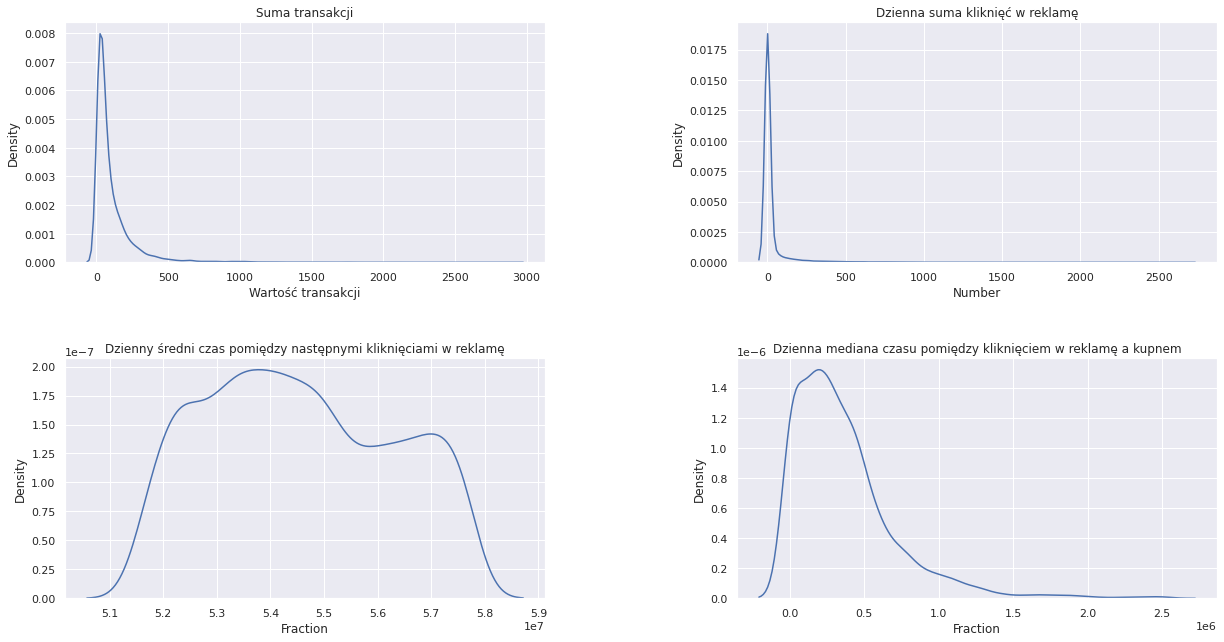

In [ ]:
sns.set()
fig, axes = plt.subplots(2, 2, figsize=(20, 10))

sns.kdeplot(grouped_sum_of_transactions, ax=axes[0, 0])
axes[0, 0].set_title('Suma transakcji')
axes[0, 0].set_xlabel('Wartość transakcji')
axes[0, 0].set_ylabel('Density')

sns.kdeplot(grouped_nb_clicks, ax=axes[0, 1])
axes[0, 1].set_title('Dzienna suma kliknięć w reklamę')
axes[0, 1].set_xlabel('Number')
axes[0, 1].set_ylabel('Density')

sns.kdeplot(grouped_time_since, ax=axes[1, 0])
axes[1, 0].set_title('Dzienny średni czas pomiędzy następnymi kliknięciami w reklamę')
axes[1, 0].set_xlabel('Fraction')
axes[1, 0].set_ylabel('Density')

sns.kdeplot(grouped_mean_time_for_conv, ax=axes[1, 1])
axes[1, 1].set_title('Dzienna mediana czasu pomiędzy kliknięciem w reklamę a kupnem')
axes[1, 1].set_xlabel('Fraction')
axes[1, 1].set_ylabel('Density')

fig.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
fig.show()

Wylosujmy próby losowe z naszych zbiorów danych

In [ ]:
grouped_sum_of_transactions_sample = grouped_sum_of_transactions.sample(frac=0.0025, random_state=42)
grouped_nb_clicks_sample = grouped_nb_clicks.sample(frac=0.0025, random_state=42)
grouped_time_since_sample = grouped_time_since.sample(frac=0.0025, random_state=42)
grouped_mean_time_for_conv_sample = grouped_mean_time_for_conv.sample(frac=0.0025, random_state=42)

In [ ]:
print("Liczność wylosowanej próby: ", len(grouped_sum_of_transactions_sample))

Liczność wylosowanej próby:  39


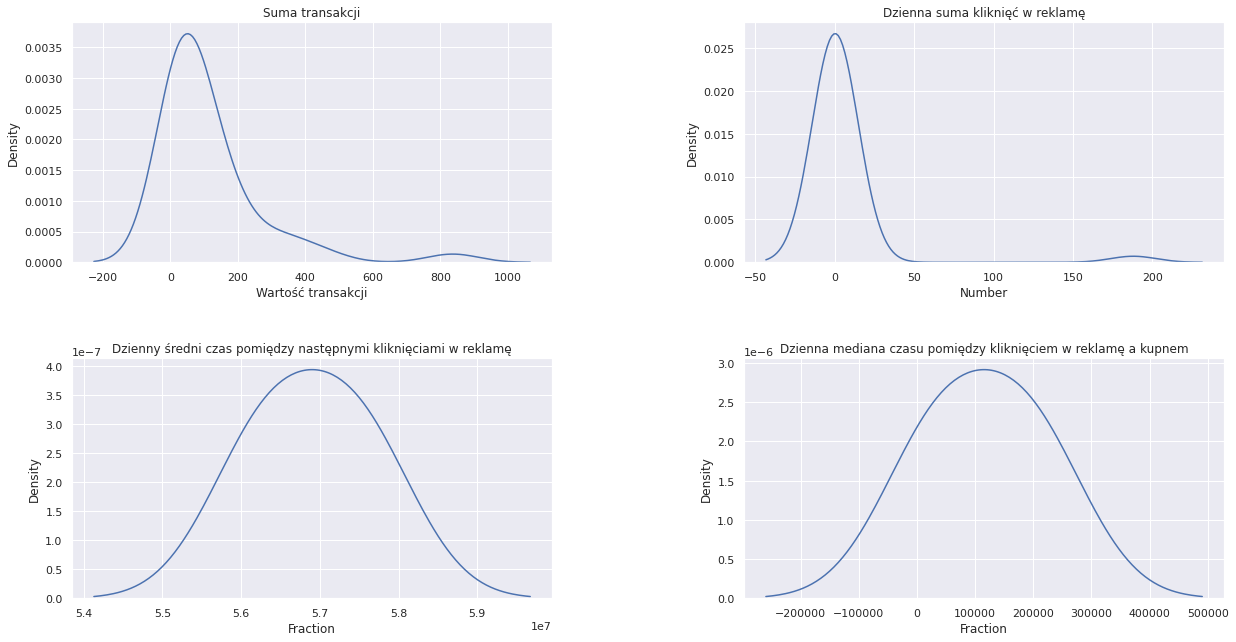

In [ ]:
sns.set()
fig, axes = plt.subplots(2, 2, figsize=(20, 10))

sns.kdeplot(grouped_sum_of_transactions_sample, ax=axes[0, 0])
axes[0, 0].set_title('Suma transakcji')
axes[0, 0].set_xlabel('Wartość transakcji')
axes[0, 0].set_ylabel('Density')

sns.kdeplot(grouped_nb_clicks_sample, ax=axes[0, 1])
axes[0, 1].set_title('Dzienna suma kliknięć w reklamę')
axes[0, 1].set_xlabel('Number')
axes[0, 1].set_ylabel('Density')

sns.kdeplot(grouped_time_since_sample, ax=axes[1, 0])
axes[1, 0].set_title('Dzienny średni czas pomiędzy następnymi kliknięciami w reklamę')
axes[1, 0].set_xlabel('Fraction')
axes[1, 0].set_ylabel('Density')

sns.kdeplot(grouped_mean_time_for_conv_sample, ax=axes[1, 1])
axes[1, 1].set_title('Dzienna mediana czasu pomiędzy kliknięciem w reklamę a kupnem')
axes[1, 1].set_xlabel('Fraction')
axes[1, 1].set_ylabel('Density')

fig.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
fig.show()

###Test statystyczny dla sumy tranzakcji

In [ ]:
print("Mediana z próby: ", round(np.median(grouped_sum_of_transactions_sample), 2))

Mediana z próby:  58.8


Czy na poziomie istotności wynoszącym 5% możemy przyjąć, że średnio kliencji robią zakupy na kwotę około 115 Euro
$$H_0:μ_0=58.8$$
$$H_1:\mu_1\neq58.8$$

In [ ]:
mu_pop = np.median(grouped_sum_of_transactions)
sigma_pop = np.std(grouped_sum_of_transactions)
alpha = 0.05

ratio = grouped_sum_of_transactions_sample
mu = np.median(ratio)
n = len(ratio)

stats, p_value = test.ztest(ratio, value=mu_pop, alternative='two-sided')

if (p_value >= alpha/2):
  print('Brak podstaw do odrzucenia hipotezy zerowej')
else:
  print('Odrzucamy hipotezę zerową i przyjmujemy hipotezę alternatywną')

Odrzucamy hipotezę zerową i przyjmujemy hipotezę alternatywną


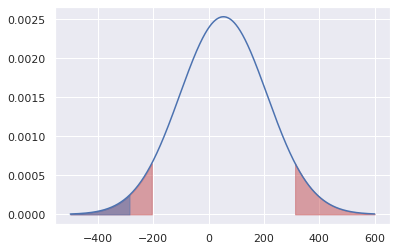

In [ ]:
x_axis = np.arange(-500, 600, 0.1)
y_axis = norm.pdf(x_axis, mu_pop, sigma_pop)
plt.fill_between(x_axis, y_axis, where=x_axis < norm.ppf(0.05, loc=mu_pop, scale=sigma_pop), alpha=0.5, color='r')
plt.fill_between(x_axis, y_axis, where=x_axis > norm.ppf(0.95, loc=mu_pop, scale=sigma_pop), alpha=0.5, color='r')
plt.fill_between(x_axis, y_axis, where=x_axis < norm.ppf(p_value, loc=mu_pop, scale=sigma_pop), alpha=0.5, color='b')
plt.plot(x_axis, y_axis)
plt.show()

Przy zadanym poziomie istotności odrzucamy hipotezę zerową. Zatem dzienna suma tranzakcji dla pary (dzien, prod_id) jest różna od 58.8 Euro.

###Test statystyczny dla dziennej sumy kliknięć w reklamę

In [ ]:
print("Mediana z próby: ", round(np.mean(grouped_nb_clicks_sample), 2))

Mediana z próby:  5.1


Sprawdźmy czy na standardowym poziomie istotności dzienna liczba kliknięć w dany produkt jest równą 5.1
$$H_0:\mu_0=5.1$$
$$H_1:\mu_0\neq5.1$$

In [ ]:
mu_pop = np.median(grouped_nb_clicks)
sigma_pop = np.std(grouped_nb_clicks)
alpha = 0.05

ratio = grouped_nb_clicks_sample
mu = np.median(ratio)
n = len(ratio)

stats, p_value = test.ztest(ratio, value=mu_pop, alternative='two-sided')

if (p_value >= alpha/2):
  print('Brak podstaw do odrzucenia hipotezy zerowej')
else:
  print('Odrzucamy hipotezę zerową i przyjmujemy hipotezę alternatywną')

Brak podstaw do odrzucenia hipotezy zerowej


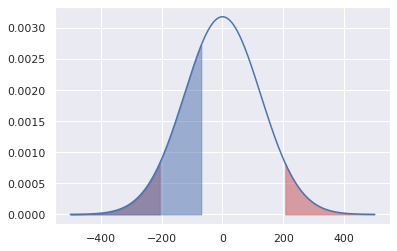

In [ ]:
x_axis = np.arange(-500, 500, 0.1)
y_axis = norm.pdf(x_axis, mu_pop, sigma_pop)
plt.fill_between(x_axis, y_axis, where=x_axis < norm.ppf(0.05, loc=mu_pop, scale=sigma_pop), alpha=0.5, color='r')
plt.fill_between(x_axis, y_axis, where=x_axis > norm.ppf(0.95, loc=mu_pop, scale=sigma_pop), alpha=0.5, color='r')
plt.fill_between(x_axis, y_axis, where=x_axis < norm.ppf(p_value, loc=mu_pop, scale=sigma_pop), alpha=0.5, color='b')
plt.plot(x_axis, y_axis)
plt.show()

Dla podanych powyżej załóżeń otrzymujemy brak podstaw do odrzucenia hipotezy zerowej. Zatem możemy przyjąc, że średnio dany produkt jest wyświetlany ("klikany") około 5 razy.

###Test statystyczny dla średniego dziennego czasu pomiędzy kliknięciem w reklamę, a dokonaniem tranzakcji

In [ ]:
print("Średnia z próby: ", round(st.median(grouped_mean_time_for_conv), 2))

Średnia z próby:  143428.39


Sprawdźmy, czy średni dzienny czas pomiędzy kliknięciem w dany produkt a kupnem jest równy 143428.39 jednostek czasu.
$$H_0:\mu_0=143428.39$$
$$H_1:\mu_0\neq143428.39$$

In [ ]:
mu_pop = st.median(grouped_mean_time_for_conv)
sigma_pop = np.std(grouped_mean_time_for_conv)
alpha = 0.05

ratio = grouped_mean_time_for_conv_sample
mu = np.mean(ratio)
n = len(ratio)

stats, p_value = test.ztest(ratio, value=mu_pop, alternative='two-sided')

if (p_value >= alpha/2):
  print('Brak podstaw do odrzucenia hipotezy zerowej')
else:
  print('Odrzucamy hipotezę zerową i przyjmujemy hipotezę alternatywną')

Odrzucamy hipotezę zerową i przyjmujemy hipotezę alternatywną


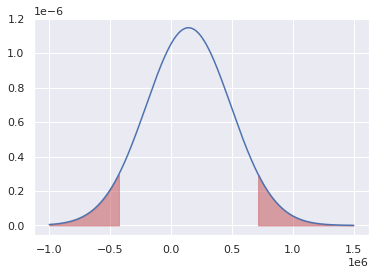

In [ ]:
x_axis = np.arange(-1000000, 1500000, 10)
y_axis = norm.pdf(x_axis, mu_pop, sigma_pop)
plt.fill_between(x_axis, y_axis, where=x_axis < norm.ppf(0.05, loc=mu_pop, scale=sigma_pop), alpha=0.5, color='r')
plt.fill_between(x_axis, y_axis, where=x_axis > norm.ppf(0.95, loc=mu_pop, scale=sigma_pop), alpha=0.5, color='r')
plt.fill_between(x_axis, y_axis, where=x_axis < norm.ppf(p_value, loc=mu_pop, scale=sigma_pop), alpha=0.5, color='b')
plt.plot(x_axis, y_axis)
plt.show()

Dla podanych powyżej załóżeń otrzymujemy brak podstaw do odrzucenia hipotezy zerowej. Zatem możemy przyjąc, że średnio czas pomiędzy odsłoną danego produktu, a dokonaniem tranzakcji jest różny od 143428.39 jednostek czasu.

##<a name=7></a>Dekompozycja widmowa zbioru wyselekcjonowanych zmiennych opisujących

In [ ]:
# na początek sprawdźmy jaki jest kształt zbioru wyselekcjonowanych danych df1
print("Rozmar zbioru df1: ", df1.shape)

Rozmar zbioru df1:  (19307, 50)


In [ ]:
# przystępujemy do dekompozycji widmowej
pca = PCA(n_components=2)

new_df = pca.fit_transform(df1)

data_frame = pd.DataFrame(new_df)

In [ ]:
print("Rozmiar zbioru po dekompozycji: ", new_df.shape)

Rozmiar zbioru po dekompozycji:  (19307, 2)


##<a name=8></a>Testowanie statystyczne głównych składowych zmiennych opisujących

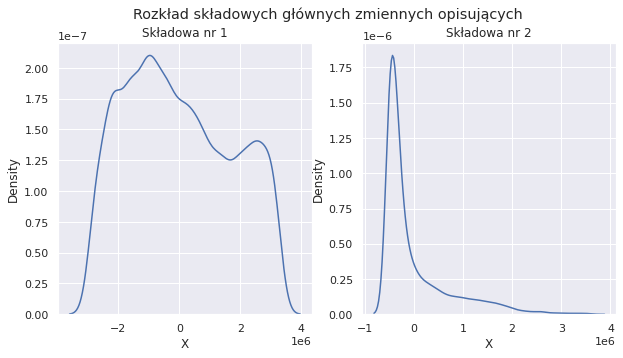

In [ ]:
# Wizualizacja składowych głównych zmiennych opisujących
sns.set()
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Rozkład składowych głównych zmiennych opisujących')

sns.kdeplot(data_frame[0], ax=axes[0])
axes[0].set_title('Składowa nr 1')
axes[0].set_xlabel('X')
axes[0].set_ylabel('Density')

sns.kdeplot(data_frame[1], ax=axes[1])
axes[1].set_title('Składowa nr 2')
axes[1].set_xlabel('X')
axes[1].set_ylabel('Density')

fig.show()

In [ ]:
# Na początek wybieramy próby losowe
sample = data_frame.sample(frac=0.002, random_state=42)

###Test zmiennej nr 1

$$H_0:\mu_0=457220$$
$$H_1:\mu_0\neq457220$$

Rozmiar próby losowej:  39
Mediana próby:  457220


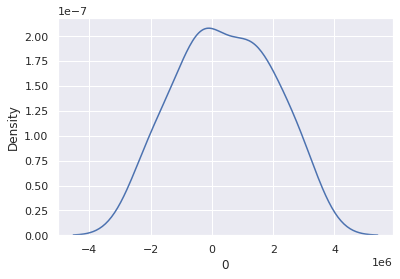

In [ ]:
sns.kdeplot(sample[0])
print("Rozmiar próby losowej: ", len(sample))
print("Mediana próby: ", round(np.median(sample[0])))

In [ ]:
mu_pop = st.median(data_frame[0])
sigma_pop = np.std(data_frame[0])
alpha = 0.05

ratio = sample[0]
mu = np.median(ratio)
n = len(ratio)

stats, p_value = test.ztest(ratio, value=mu_pop, alternative='two-sided')

if (p_value >= alpha/2):
  print('Brak podstaw do odrzucenia hipotezy zerowej')
else:
  print('Odrzucamy hipotezę zerową i przyjmujemy hipotezę alternatywną')

Odrzucamy hipotezę zerową i przyjmujemy hipotezę alternatywną


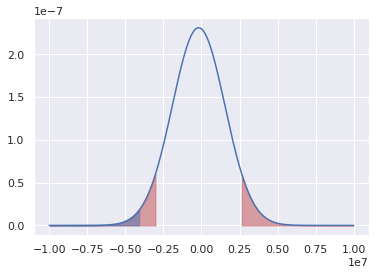

In [ ]:
x_axis = np.arange(-10000000, 10000000, 100)
y_axis = norm.pdf(x_axis, mu_pop, sigma_pop)
plt.fill_between(x_axis, y_axis, where=x_axis < norm.ppf(0.05, loc=mu_pop, scale=sigma_pop), alpha=0.5, color='r')
plt.fill_between(x_axis, y_axis, where=x_axis > norm.ppf(0.95, loc=mu_pop, scale=sigma_pop), alpha=0.5, color='r')
plt.fill_between(x_axis, y_axis, where=x_axis < norm.ppf(p_value, loc=mu_pop, scale=sigma_pop), alpha=0.5, color='b')
plt.plot(x_axis, y_axis)
plt.show()

Na przyjętym poziomie istotności wynoszącym 5% odrzucamy hipotezę zerową. Zatem w wylosowanej próbie mediana jest różna niż mediana populacji.

###Test zmiennej nr 2

$$H_0:\mu_0=-339529$$
$$H_1:\mu_0\neq-339529$$

Rozmiar próby losowej:  39
Mediana próby:  -339529


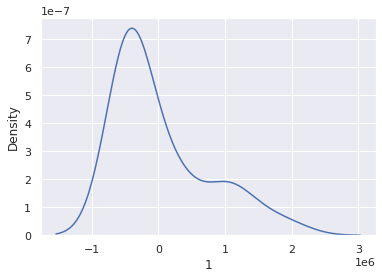

In [ ]:
sns.kdeplot(sample[1])
print("Rozmiar próby losowej: ", len(sample))
print("Mediana próby: ", round(np.median(sample[1])))

In [ ]:
mu_pop = st.median(data_frame[1])
sigma_pop = np.std(data_frame[1])
alpha = 0.05

ratio = sample[1]
mu = np.median(ratio)
n = len(ratio)

stats, p_value = test.ztest(ratio, value=mu_pop, alternative='two-sided')

if (p_value >= alpha/2):
  print('Brak podstaw do odrzucenia hipotezy zerowej')
else:
  print('Odrzucamy hipotezę zerową i przyjmujemy hipotezę alternatywną')

Odrzucamy hipotezę zerową i przyjmujemy hipotezę alternatywną


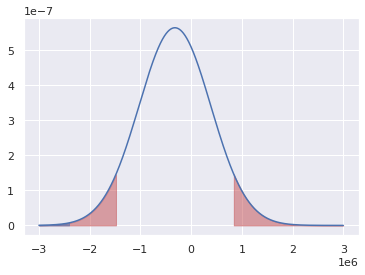

In [ ]:
x_axis = np.arange(-3000000, 3000000, 100)
y_axis = norm.pdf(x_axis, mu_pop, sigma_pop)
plt.fill_between(x_axis, y_axis, where=x_axis < norm.ppf(0.05, loc=mu_pop, scale=sigma_pop), alpha=0.5, color='r')
plt.fill_between(x_axis, y_axis, where=x_axis > norm.ppf(0.95, loc=mu_pop, scale=sigma_pop), alpha=0.5, color='r')
plt.fill_between(x_axis, y_axis, where=x_axis < norm.ppf(p_value, loc=mu_pop, scale=sigma_pop), alpha=0.5, color='b')
plt.plot(x_axis, y_axis)
plt.show()

Na przyjętym poziomie istotności wynoszącym 5% odrzucamy hipotezę zerową. Zatem w wylosowanej próbie mediana jest różna niż mediana populacji.